In [3]:
import pandas as pd
import numpy as np
from scipy.stats import nbinom, beta
from concurrent.futures import ThreadPoolExecutor, as_completed

### Precomputations

To improve runtime of Bayesian method, precompute PMF and CMF of negative binomial distribution. Also precompute conditional sales probabilities.<br>
note: $p_{idx}$ corresponds to the index in the grid $0.900, 0.901, ..., 0.990$
<br><br>
pmf_table[$n,r,p_{idx}$] = nbinom.pmf($n,r,p$) where $p = 0.900+p_{idx}*0.001$<br>
cmf_table[$n,r,p_idx$] = nbinom.cmf($n,r,p$) where $p = 0.900+p_{idx}*0.001$<br>
cond_pmf_sales[$X, s, r, p_{idx}$] = P($X$ sales with $s$ inventory and demand ~ NB($r,p$)) where $p = 0.900+p_{idx}*0.001$<br>
<br>
We choose to precompute above values up to $n=200, r=300, X=200, s=200$ as these upper bounds will cover most data points. For remaining cases not included in the tables, we directly compute them.

In [4]:
#upper bounds for initial NB precomputing
max_n = 200
max_r = 300

#non-parametric p distribution values for NB fitting
p_grid = np.linspace(0.900, 0.990, 91)

def precompute_NB ():
    '''
    Calculates tables containing NB pmf and cmf values up to given bounds.
    Output: two tables with shape (max_n, max_r, len(p_grid))
    '''
    pmf_table = np.zeros((max_n+1, max_r +1, len(p_grid)))
    cmf_table = np.zeros((max_n+1, max_r +1, len(p_grid)))
    for p_idx, p in enumerate(p_grid):
        for r in range(max_r+1):
            pmf_table[:, r, p_idx] = nbinom.pmf(np.arange(0,max_n+1), r, p)
            cmf_table[:, r, p_idx] = nbinom.cdf(np.arange(0,max_n+1), r, p)
    np.save("pmf_table.npy", pmf_table)
    np.save("cmf_table.npy", cmf_table)

def precompute_cond_pmf_sale():
    '''
    Calculates table containing conditional pmf sales (given demand~NB(r,p) and inventory is s)
    For uncensored sales (X < s): table returns nbinom.pmf(X, r, p)
    For censored sales (X >= s): table returns 1 - nbinom.cmf(s-1, r, p)

    Output: one table with shape (max_n, max_n, max_r, len(p_grid))
    Specifically, value at index (X, s, r, p) represents probability of getting X sales given demand~NB(r,p) and inventory is s
    '''
    cond_pmf_sale = np.zeros((max_n+1, max_n+1, max_r+1, len(p_grid)))

    for p_idx, p in enumerate(p_grid):
        for X in range(max_n+1):
            for s in range(max_n+1):
                for r in range(max_r+1):
                    cond_pmf_sale[X, s, r, p_idx] = pmf_table[X, r, p_idx] if X < s else 1 - cmf_table[s-1, r, p_idx]
    np.save("cond_pmf_sale_table.npy", cond_pmf_sale)

In [ ]:
precompute_NB()
pmf_table = np.load('pmf_table.npy')
cmf_table = np.load('cmf_table.npy')
#precompute_cond_pmf_sale()
cond_pmf_sales_table = np.load('cond_pmf_sale_table.npy')

print(pmf_table.shape) # (201,301,91)
print(cmf_table.shape) # (201,301,91)
print(cond_pmf_sales_table.shape) # (201,201,301,91)

FileNotFoundError: [Errno 2] No such file or directory: 'pmf_table.npy'

### Bayesian Algorithm

In [ ]:
def quantile_quantity(r, c_ratio, pmf_p, lo=0, hi=100):
    '''
    Returns minimum order quantity such that predicted demand is above the critical ratio
    '''
    # Use binary search to determine lowest value such that quantile > critical ratio
    # quantile at mid = ∑_(demand = 0 to mid)∑_(p_grid)  pmf(demand, r, p)*π(p)
    while lo < hi:
        mid = (lo + hi) // 2
        
        if mid > max_n or r > max_r:
            quantile =  np.sum([np.dot(nbinom.pmf(y, r, p_grid), pmf_p) for y in range(int(mid) + 1)])
        else:
            quantile = np.sum([np.dot(pmf_table[y, r, :], pmf_p) for y in range(int(mid) + 1)])

        if quantile < c_ratio:
            lo = mid + 1
        else:
            hi = mid
    return lo

def uncensor(r, pmf_p, s, max):
    '''
    Calculate E[X|X>=s, X~NB(r, p)] with p distribution = pmf_p
    max: upper demand limit used in calculation
    '''
    # tail_prob = probability of demand >=s = ∑_(p_grid) sf(s, r, p)*π(p)
    # pmf = pmf of demand s to max (entry for demand x = ∑_(p_grid) pmf(x, r, p)*π(p))
    if r > max_r or max > max_n:
        pmf = nbinom.pmf(np.arange(s,max+1)[:, None], r, np.array(p_grid)) @ pmf_p.T #shape = (max+1-s,1)
        tail_prob = np.dot(1 - nbinom.cdf(s-1, r, p_grid)[None, :], pmf_p.T).item()
    else:
        pmf = np.dot(pmf_table[s:max+1, r,:], pmf_p)
        tail_prob = np.dot(1 - cmf_table[s-1, r,:], pmf_p)

    if tail_prob < 1e-8:
        return s  # fallback: don't uncensor (demand>=s is unlikely)
    
    exp = np.dot(np.arange(s,max+1), pmf)/tail_prob
    return int(np.round(exp))

def compute_bayesian_result(group_key_data, c_ratio):
    '''
    given one pos group and critical ratio, calculate the bayesian demand and order quantity
    if there is no 2022-2023 data or if mean 2022-2023 sales is too low (<0.052), this pos is skipped
    '''
    (pos,), group = group_key_data
    group = group.dropna(subset=['Bezug', 'Verkauf'])
    results = []

    #determine appropriate r value using 2022-2023 mean sales
    train_data = group[group['Heftjahr']<2024]
    if len(train_data) == 0:
        print(f'skipped, {pos} has no 2022-2023 data points')
        return
    else:
        mean_2223 = train_data['Verkauf'].mean()
        r = int(mean_2223*0.95/0.05)+1 #NB(r, 0.95) has mean ≈ mean(2022-2023 sales)
        if r == 0.0:
            print(f'skipped, {pos} has r = 0')
            return #don't use Bayesian for this POS

    # initialize distribution of p, π, to Uniform
    pmf_p = np.full(len(p_grid), 1.0 / len(p_grid))

    #update π with each new verkauf-bezug data point
    for row in group.itertuples():
        #cond_sale_probs = probability of sale given demand~NB(r,p) and inventory level
        if row.Bezug > max_n or r > max_r:
            cond_sale_probs = [nbinom.pmf(row.Verkauf, r, p) if row.Verkauf < row.Bezug else 1-nbinom.cdf(row.Bezug - 1, r, p) for p in p_grid] #shape = len(p_grid)
        else:
            cond_sale_probs = cond_pmf_sales_table[int(row.Verkauf), int(row.Bezug), r, :]  #shape = len(p_grid)
            
        sale_prob = np.dot(cond_sale_probs, pmf_p) #summed over all p values

        #do not update π if probability of sale is too low
        if sale_prob != 0.0:
            pmf_p *= cond_sale_probs / sale_prob
        
        ub = max(50,2*int(train_data['Verkauf'].max()))
        Q = quantile_quantity(r, c_ratio, pmf_p, lo=0, hi=ub)
        if Q == ub: print(f'{pos}, {row.Period}, reached max Q of {Q}') #check if upper bound is limiting Q output

        if row.Zensiert == 1: demand = uncensor(r, pmf_p, int(row.Bezug), max= ub)
        else: demand = row.Verkauf

        results.append({'EHASTRA_EH_NUMMER': pos, 'Period':row.Period, 'Bayesian_Demand': demand, 'Bayesian_Q': Q})

    print(f'{pos}, r = {r}, final pmf_p: {pmf_p}')
    return pd.DataFrame(results)


def bayesian_parallel_pos(df, c_ratio, max_cpus = None):
    '''
    Group magazine data by pos and run bayesian algorithm in parallel.
    Returns original dataframe with new columns Bayesian_Demand, and Bayesian_Q
    '''
    #Step 1: calculate Bayesian Demand and Q values
    df.sort_values(['EHASTRA_EH_NUMMER', 'Period'], inplace=True)
    grouped = df.groupby(['EHASTRA_EH_NUMMER'])
    grouped = list(grouped)
    results = []

    with ThreadPoolExecutor(max_workers=max_cpus) as executor:
        futures  = [executor.submit(compute_bayesian_result, group, c_ratio) for group in grouped]
        for future in as_completed(futures):
            if future.result() is not None: results.append(future.result())
    df_Bayesian = pd.concat(results)

    #Step 2: add results to original dataframe
    df_join = pd.merge(df, df_Bayesian, how="outer", on=['EHASTRA_EH_NUMMER', 'Period'])
    df_join.set_index(['EHASTRA_EH_NUMMER', 'Period'])

    # Step 3: For POS where Bayesian does not work, fill in missing demand predictions with verkauf. Missing Q values are not changed
    df_join.loc[df_join['Verkauf'].notna() & df_join['Bayesian_Demand'].isna(), 'Bayesian_Demand'] = df_join['Verkauf']
    return df_join


In [ ]:
df = pd.read_csv('original_data/I_20250212_ZQ0.35_ZG0.4_testfile.csv')
df_Bayesian = bayesian_parallel_pos(df, c_ratio=0.9)

skipped, EHA0200159 has no 2022-2023 data points
skipped, EHA1580790 has no 2022-2023 data points
EHA0916947, r = 1, final pmf_p: [0.00995966 0.00998181 0.01000398 0.01002617 0.01004839 0.01007063
 0.0100929  0.01011519 0.01013751 0.01015985 0.01018222 0.01020461
 0.01022702 0.01024946 0.01027193 0.01029442 0.01031693 0.01033947
 0.01036203 0.01038462 0.01040723 0.01042987 0.01045253 0.01047522
 0.01049793 0.01052066 0.01054342 0.0105662  0.01058901 0.01061185
 0.01063471 0.01065759 0.0106805  0.01070343 0.01072638 0.01074936
 0.01077237 0.0107954  0.01081845 0.01084153 0.01086464 0.01088777
 0.01091092 0.0109341  0.0109573  0.01098053 0.01100378 0.01102705
 0.01105036 0.01107368 0.01109703 0.0111204  0.0111438  0.01116723
 0.01119068 0.01121415 0.01123765 0.01126117 0.01128471 0.01130829
 0.01133188 0.0113555  0.01137915 0.01140282 0.01142651 0.01145023
 0.01147397 0.01149774 0.01152153 0.01154535 0.01156919 0.01159306
 0.01161695 0.01164086 0.0116648  0.01168877 0.01171276 0.01173677

### Explore Results

Text(0.5, 1.0, 'Final distribution of p parameter - Magazine E EHE1503272')

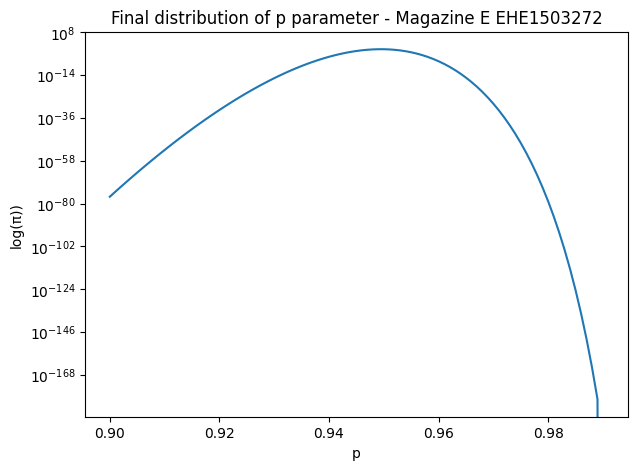

In [5]:
#look at bayesian fit
import matplotlib.pyplot as plt
r=406
s = "[3.05690023e-077 1.05546534e-074 3.40602146e-072 1.02615423e-069 2.88300650e-067 7.54460043e-065 1.83678286e-062 4.15495510e-060 8.72167122e-058 1.69659043e-055 3.05420098e-053 5.08089616e-051 7.79942255e-049 1.10305925e-046 1.43502949e-044 1.71449062e-042 1.87794408e-040 1.88251041e-038 1.72387166e-036 1.43933277e-034 1.09358106e-032 7.54546898e-031 4.71785496e-029 2.66727280e-027 1.36037341e-025 6.24424503e-024 2.57308338e-022 9.49415646e-021 3.12836202e-019 9.17942747e-018 2.39155073e-016 5.51545073e-015 1.12236248e-013 2.00857080e-012 3.15012851e-011 4.31391761e-010 5.13876711e-009 5.30336679e-008 4.72202369e-007 3.61141242e-006 2.36152050e-005 1.31390367e-004 6.18835459e-004 2.45410434e-003 8.14814415e-003 2.25154307e-002 5.14543643e-002 9.66039344e-002 1.47959268e-001 1.83497145e-001 1.82821731e-001 1.45110919e-001 9.09456443e-002 4.45823600e-002 1.69225555e-002 4.92064143e-003 1.08353669e-003 1.78483171e-004 2.17053756e-005 1.92140936e-006 1.21944044e-007 5.45866661e-009 1.69329528e-010 3.57116700e-012 5.01575783e-014 4.58728807e-016 2.66592237e-018 9.58560082e-021 2.07103424e-023 2.60395217e-026 1.83924356e-029 7.01934692e-033 1.38636268e-036 1.35071314e-040 6.15362563e-045 1.23471166e-049 1.01999829e-054 3.21479998e-060 3.54531121e-066 1.23932849e-072 1.22587745e-079 3.00902518e-087 1.57300568e-095 1.46363507e-104 1.96003915e-114 2.93025413e-125 3.59740662e-137 2.49038110e-150 6.09553599e-165 2.92601113e-181 0.00000000e+000]"
pmf_p = list(map(float, s.strip("[]").split()))
fig, ax = plt.subplots(figsize=(7,5))
plt.plot(p_grid, pmf_p)
ax.set_yscale('log')
plt.xlabel('p')
plt.ylabel('log(π))')
plt.title(f'Final distribution of p parameter - Magazine E {pos}')


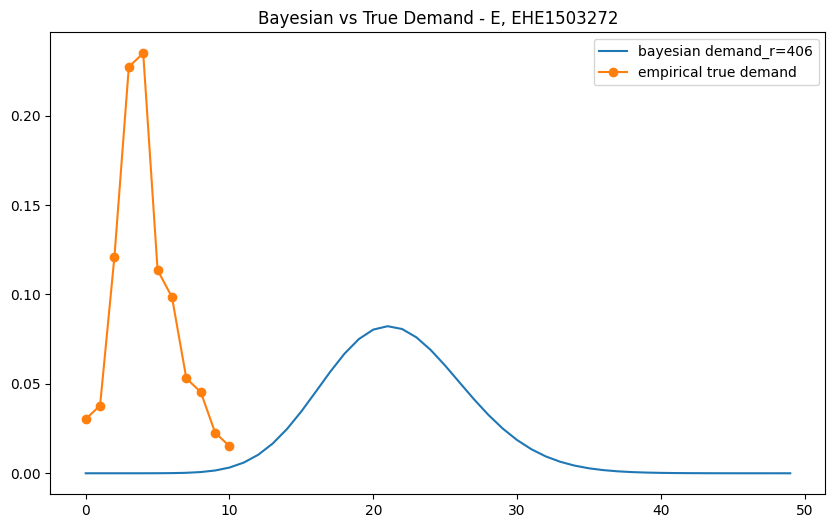

In [6]:
X = np.arange(0,50,1)
pmf_X = [np.sum([prob*nbinom.pmf(x, r, p) for p, prob in zip(p_grid, pmf_p)]) for x in X]

plt.figure(figsize=(10, 6))
plt.plot(X, pmf_X, label = f'bayesian demand_r={r}')
df = pd.read_csv("original_data/A_20250212_ZQ0.35_ZG0.4_testfile.csv", delimiter=",")
df = df[df['EHASTRA_EH_NUMMER']==pos]
sales_counts = df['Verkauf_MBR'].value_counts().sort_index()
sales_distribution = sales_counts/sales_counts.sum()
plt.plot(sales_distribution.index, sales_distribution.values, marker='o', linestyle='-', label = 'empirical true demand')
plt.title(f'Bayesian vs True Demand - E, {pos}')

plt.legend()

### Explore Data

In [25]:
#check r value counts
letter = 'E'
df= pd.read_csv('original_data/'+letter+'_20250212_ZQ0.35_ZG0.4_testfile.csv')
r_results = []
df.dropna(inplace=True)
for (pos, ), group in df.groupby(['EHASTRA_EH_NUMMER']):
    train_data = group[group['Heftjahr']<2024]
    if len(train_data)<1: r=-1
    else:
        mean_2223 = train_data['Verkauf'].mean()
        r = int(mean_2223*0.95/0.05) #NB(r, 0.95) has mean = mean_2223
    r_results.append({'pos': pos, 'r': r})
r_df = pd.DataFrame(r_results)
r_df.sort_values(['r'], inplace=True)
print(r_df['r'].value_counts().sort_index()[-20:])
print(r_df['r'].value_counts().sort_index()[:5])

r
217     1
222     3
227     1
229     1
236     1
238     2
260     1
261     1
264     1
274     1
298     1
312     1
313     1
364     1
406     1
445     1
475     1
500     1
735     1
3037    1
Name: count, dtype: int64
r
-1    205
 0    261
 1     41
 2     50
 3     53
Name: count, dtype: int64


In [16]:
for letter in 'ABCDEFGHI':
    df= pd.read_csv('original_data/'+letter+'_20250212_ZQ0.35_ZG0.4_testfile.csv')
    print('-----'+letter+'-----')
    print('max order quantity: ', df['Bezug'].max())
    print('max sales quantity: ', df['Verkauf'].max())
    r_max=0
    pos_max = 'pos'
    for (pos, ), group in df.groupby(['EHASTRA_EH_NUMMER']):
        train_data = group[group['Heftjahr']<2024]
        if len(train_data)<1: r=1
        else:
            mean_2223 = train_data['Verkauf'].mean()
            r = mean_2223*0.95/0.05 #NB(r, 0.95) has mean = mean_2223
        if r > r_max:
            r_max=r
            pos_max = pos
    print('max r: ', r_max, 'at pos ', pos_max)

-----A-----
max order quantity:  114.0
max sales quantity:  87.0
max r:  622.5728155339805 at pos  EHI2908886
-----B-----
max order quantity:  330.0
max sales quantity:  220.0
max r:  1880.26213592233 at pos  EHJ2736660
-----C-----
max order quantity:  53.0
max sales quantity:  48.0
max r:  361.7378640776699 at pos  EHG2977334
-----D-----
max order quantity:  80.0
max sales quantity:  69.0
max r:  670.7826086956521 at pos  EHJ2736660
-----E-----
max order quantity:  694.0
max sales quantity:  694.0
max r:  3037.076923076923 at pos  EHF1974949
-----F-----
max order quantity:  76.0
max sales quantity:  67.0
max r:  556.7441860465116 at pos  EHI6259184
-----G-----
max order quantity:  35.0
max sales quantity:  23.0
max r:  235.17777777777775 at pos  EHI6259184
-----H-----
max order quantity:  121.0
max sales quantity:  120.0
max r:  2280.0 at pos  EHB5690654
-----I-----
max order quantity:  101.0
max sales quantity:  67.0
max r:  692.7692307692306 at pos  EHB6767359
